# Setup

In [1]:
# --- 1. SETUP DAN INSTALASI ---
!pip install transformers torch pandas tqdm

import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset, SequentialSampler
import numpy as np
import os
from tqdm import tqdm # Untuk progress bar

# Tentukan device (GPU jika ada)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Menggunakan device: cuda


# Load Model dan Data

In [2]:
# --- 2. MUAT MODEL & DATA YANG AKAN DIPREDIKSI ---

# Path ke model yang sudah Anda latih
model_path = './model_sentiment_indobert_final'

# Path ke data bersih (semua data, BUKAN hanya yang berlabel)
data_path = '../Dataset/Data-Bersih-Untuk-BERT.csv'
output_path = '../Dataset/Hasil_Bert.csv'

# Muat tokenizer dan model
print("Memuat model dan tokenizer...")
try:
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval() # PENTING: Set model ke mode evaluasi
    print("Model dan tokenizer berhasil dimuat.")
except OSError:
    print(f"ERROR: Tidak dapat menemukan model di '{model_path}'.")
    print("Pastikan path Anda sudah benar.")
    # Hentikan jika model tidak ada
    raise

# Muat data yang akan diprediksi
try:
    df = pd.read_csv(data_path)
    print(f"Berhasil memuat {len(df)} baris data dari '{data_path}'.")
except FileNotFoundError:
    print(f"ERROR: File data tidak ditemukan di '{data_path}'.")
    raise

Memuat model dan tokenizer...
Model dan tokenizer berhasil dimuat.
Berhasil memuat 2011 baris data dari '../Dataset/Data-Bersih-Untuk-BERT.csv'.


In [3]:
# --- 3. BUAT DATASET & DATALOADER UNTUK PREDIKSI ---

MAX_LEN = 128 # Gunakan MAX_LEN yang sama dengan saat training
BATCH_SIZE = 32 # Boleh lebih besar saat prediksi

# Buat kelas Dataset sederhana untuk teks (tanpa label)
class PredictionDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Buat dataset dan dataloader
texts_to_predict = df['normalized_text'].values
pred_dataset = PredictionDataset(texts_to_predict, tokenizer, MAX_LEN)
pred_dataloader = DataLoader(
    pred_dataset,
    sampler=SequentialSampler(pred_dataset),
    batch_size=BATCH_SIZE
)

# Prediksi

In [4]:
# --- 4. JALANKAN PROSES PREDIKSI (INFERENCE) ---

print("Memulai proses prediksi sentimen...")
all_predictions = []

# Gunakan torch.no_grad() untuk mematikan perhitungan gradien (hemat memori)
with torch.no_grad():
    # Gunakan tqdm untuk melihat progress bar
    for batch in tqdm(pred_dataloader, desc="Memprediksi"):
        # Pindahkan batch ke GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Dapatkan output model
        outputs = model(input_ids, attention_mask=attention_mask)

        # Ambil logits (skor mentah)
        logits = outputs.logits

        # Pindahkan logits ke CPU dan ubah ke numpy
        logits = logits.detach().cpu().numpy()

        # Ambil prediksi kelas (indeks dengan skor tertinggi)
        preds_flat = np.argmax(logits, axis=1).flatten()

        # Tambahkan ke daftar prediksi
        all_predictions.extend(preds_flat)

print(f"Prediksi selesai. Total {len(all_predictions)} prediksi dibuat.")

Memulai proses prediksi sentimen...


Memprediksi: 100%|██████████| 63/63 [00:26<00:00,  2.38it/s]

Prediksi selesai. Total 2011 prediksi dibuat.


In [5]:
display(df.head)

<bound method NDFrame.head of       created_at                                    normalized_text  \
0     2025-08-15  ya beda blok jaman moh hatta jadi wapres indon...   
1     2025-07-04  knp ini menteri gak mengundurkan diri cuma uta...   
2     2025-06-25  pak punya menteri kok gini banget pak ngawur l...   
3     2025-04-18  wakil menteri leveeeeel receeeeh level jalanan...   
4     2025-03-26  klw berargumen itu emang kerjaan pemerintah ya...   
...          ...                                                ...   
2006  2025-03-23  emg cherry picking coba ada gak yang belain ka...   
2007  2025-03-23  dri dulu aku selalu bingung kenapa sih orangor...   
2008  2025-03-22                       send meme bahlil ke dia nder   
2009  2025-03-21    karna kamu kasih meme bahlil mari kita mutualan   
2010  2025-03-15                meme tentang bahlil kocak semua yak   

     isu_teridentifikasi sentiment_pred  
0                Isu LPG        Negatif  
1            Isu Tambang        N

In [6]:
# --- 5. SIMPAN HASIL AKHIR ---

# Konversi label ID (0, 1, 2) kembali ke string ('Negatif', 'Netral', 'Positif')
# Pastikan ini SAMA PERSIS dengan label_map Anda
label_map_inv = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}

# Buat kolom baru di DataFrame Anda
df['prediksi_sentimen'] = [label_map_inv[pred] for pred in all_predictions]

# Tampilkan 5 baris pertama dari hasil akhir
print("\n--- Contoh Hasil Akhir ---")
print(df[['normalized_text', 'isu_teridentifikasi', 'sentiment_pred']].head())

# Simpan ke file CSV final
df.to_csv(output_path, index=False)
print(f"\nBERHASIL! Data analisis final telah disimpan ke: {output_path}")


--- Contoh Hasil Akhir ---
                                     normalized_text isu_teridentifikasi  \
0  ya beda blok jaman moh hatta jadi wapres indon...             Isu LPG   
1  knp ini menteri gak mengundurkan diri cuma uta...         Isu Tambang   
2  pak punya menteri kok gini banget pak ngawur l...         Isu Tambang   
3  wakil menteri leveeeeel receeeeh level jalanan...            Isu Meme   
4  klw berargumen itu emang kerjaan pemerintah ya...             Isu LPG   

  sentiment_pred  
0        Negatif  
1        Negatif  
2        Negatif  
3        Negatif  
4        Negatif  

BERHASIL! Data analisis final telah disimpan ke: ../Dataset/Hasil_Bert.csv


# Visualisasi

Berhasil memuat 2011 baris data final.


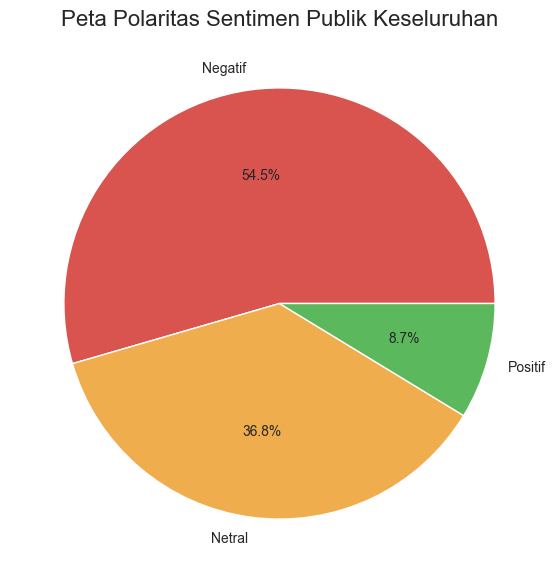


Membuat plot sentimen per isu...


<Figure size 1200x700 with 0 Axes>

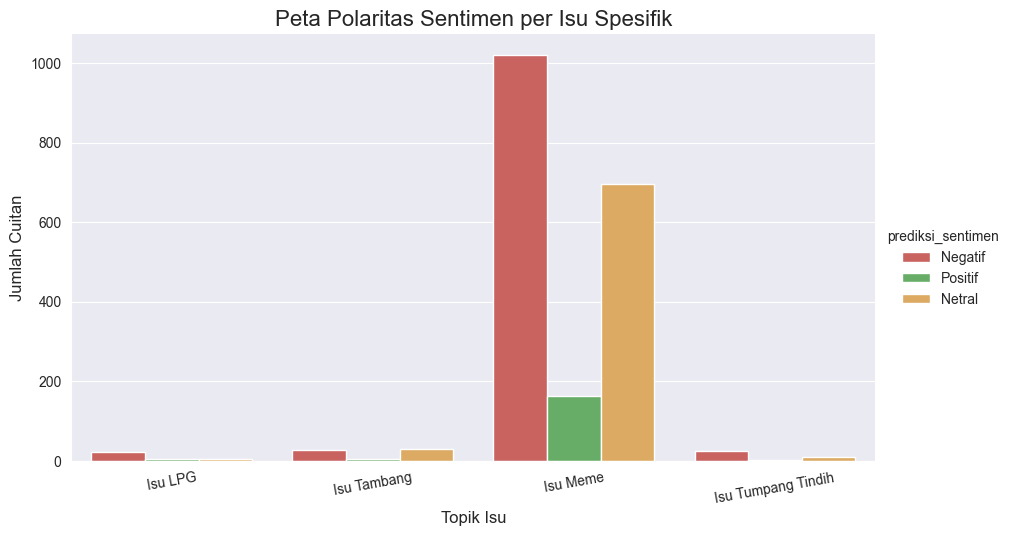

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Muat data final Anda
file_path = '../Dataset/Data_Hasil_Analisis_Final.csv'
df_final = pd.read_csv(file_path)

print(f"Berhasil memuat {len(df_final)} baris data final.")

# --- Visualisasi 1: Peta Polaritas Sentimen KESELURUHAN ---
plt.figure(figsize=(7, 7))
df_final['prediksi_sentimen'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%', # Tampilkan persentase
    colors=['#d9534f', '#f0ad4e', '#5cb85c'] # Merah, Kuning, Hijau
)
plt.title('Peta Polaritas Sentimen Publik Keseluruhan', fontsize=16)
plt.ylabel('') # Hapus label y
plt.savefig('Peta_Sentimen_Keseluruhan.png', dpi=300)
plt.show()


# --- Visualisasi 2: Peta Polaritas per ISU (Visualisasi UTAMA) ---
print("\nMembuat plot sentimen per isu...")

plt.figure(figsize=(12, 7))
# Gunakan catplot (atau countplot) dari seaborn untuk mengelompokkan
sns.catplot(
    data=df_final,
    x='isu_teridentifikasi', # Sumbu X adalah 3 Isu Anda
    kind='count',
    hue='prediksi_sentimen', # Warna didasarkan pada sentimen
    palette={'Negatif': '#d9534f', 'Netral': '#f0ad4e', 'Positif': '#5cb85c'},
    aspect=1.8 # Buat plot lebih lebar
)

plt.title('Peta Polaritas Sentimen per Isu Spesifik', fontsize=16)
plt.xlabel('Topik Isu', fontsize=12)
plt.ylabel('Jumlah Cuitan', fontsize=12)
plt.xticks(rotation=10)

output_plot_path = 'Peta Polaritas Sentimen per Isu Spesifik.png'
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
plt.show()

C:\Users\faiqa\AppData\Local\Temp\ipykernel_25228\1338569221.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


Plot bar chart Peta Sentimen Keseluruhan telah disimpan.


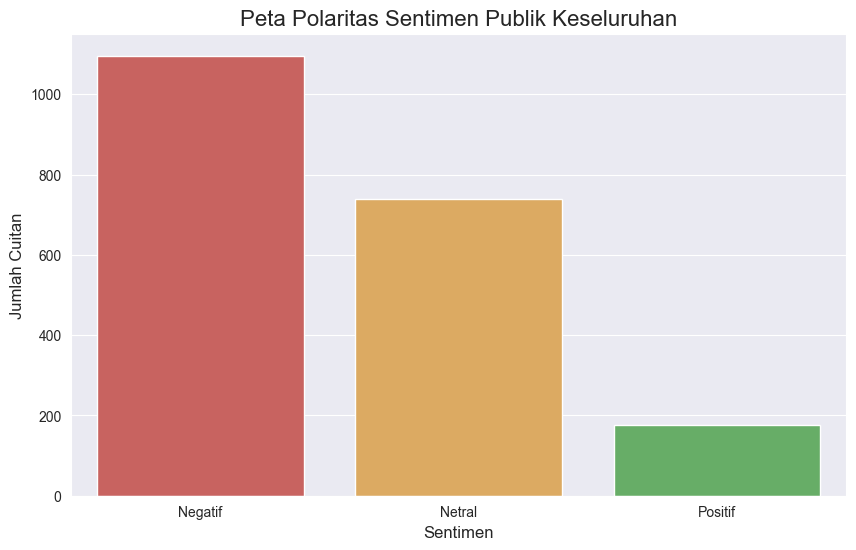

In [8]:
plt.figure(figsize=(10, 6))

# Gunakan seaborn.countplot untuk membuat bar chart secara otomatis
sns.countplot(
    data=df_final,
    x='prediksi_sentimen',
    # Urutkan bar berdasarkan jumlah (dari terbanyak ke terkecil)
    order=df_final['prediksi_sentimen'].value_counts().index,
    # Beri palet warna yang konsisten
    palette={'Negatif': '#d9534f', 'Netral': '#f0ad4e', 'Positif': '#5cb85c'}
)

plt.title('Peta Polaritas Sentimen Publik Keseluruhan', fontsize=16)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah Cuitan', fontsize=12)

# Simpan file plot
plt.savefig('Peta_Sentimen_Keseluruhan_Bar.png', dpi=300, bbox_inches='tight')
print("Plot bar chart Peta Sentimen Keseluruhan telah disimpan.")
plt.show()

## Wordcloud per Isu

In [9]:
# --- 1. SETUP DAN INSTALASI ---
!pip install wordcloud matplotlib pandas

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
import sys

print("Libraries berhasil dimuat.")

Libraries berhasil dimuat.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
# --- 2. MUAT DATA DAN TENTUKAN STOPWORDS ---

# Path ini 'naik satu level' dari 'Rule Bases' lalu masuk ke 'Dataset'
file_path = '../Dataset/Hasil_Bert.csv'

try:
    df = pd.read_csv(file_path)
    print(f"Berhasil memuat {len(df)} baris data final dari: {file_path}")

    # Pastikan teks bersih dari NaN
    df['normalized_text'] = df['normalized_text'].fillna('')

except FileNotFoundError:
    print(f"ERROR: File tidak ditemukan di '{file_path}'")
    sys.exit() # Hentikan jika file tidak ada


# --- STOPWORDS (SANGAT PENTING!) ---
# Ini adalah kunci untuk word cloud yang bagus.
# Kita buang kata-kata umum DAN kata-kata konteks yang ada di SEMUA isu.

# Stopwords umum Bahasa Indonesia
stopwords_id = set([
    'yang', 'di', 'dan', 'ini', 'itu', 'ke', 'dengan', 'untuk', 'pada', 'dari',
    'juga', 'akan', 'adalah', 'karena', 'sudah', 'telah', 'saja', 'seperti',
    'bisa', 'tidak', 'gak', 'ga', 'tapi', 'kalau', 'kalo', 'pak', 'yg', 'aja',
    'nya', 'ya', 'kok', 'sih', 'deh', 'dong', 'nih', 'tuh', 'aja', 'saja'
])

# Stopwords dari konteks penelitian Anda (yang kita temukan di LDA)
stopwords_konteks = set([
    # Tokoh/Nama
    'menteri', 'bahlil', 'lahadalia', 'pak', 'bpk',

    # Slang / Noise Percakapan Umum
    'jadi', 'sama', 'si', 'udah', 'mau', 'kalau', 'banget', 'semua', 'jelek',
    'lu', 'orang', 'lebih', 'gue', 'gw', 'buat', 'bikin', 'muka', 'aku',
    'bukan', 'masuk', 'apa', 'kamu', 'kaya', 'lucu', 'suka', 'soal', 'punya',
    'cuma', 'kayak', 'pake', 'malah', 'coba', 'kerja', 'baik', 'kak', 'makin',
    'kek', 'liat', 'terus', 'mirip', 'gua', 'wajah', 'biar', 'emang'

    # --- TAMBAHAN BARU (Noise Level 3 dari Word Cloud Terakhir) ---
    'akun', 'ketua', 'repost', 'isi', 'maaf', 'foto', 'zonauang', 'promo', 'shopee', 'spay', 'diskon', 'ffjwvp', 'referral', 'shopeepay', 'FFJWVP', 'freelance'
])

# Gabungkan semua stopwords
all_stopwords = stopwords_id.union(stopwords_konteks)
print(f"Total {len(all_stopwords)} stopwords akan digunakan.")

Berhasil memuat 2011 baris data final dari: ../Dataset/Hasil_Bert.csv
Total 98 stopwords akan digunakan.



Akan membuat word cloud untuk isu: ['Isu LPG' 'Isu Tambang' 'Isu Meme' 'Isu Tumpang Tindih']

Membuat Word Cloud untuk: Isu LPG...
Plot telah disimpan ke: wordcloud_isu_lpg.png


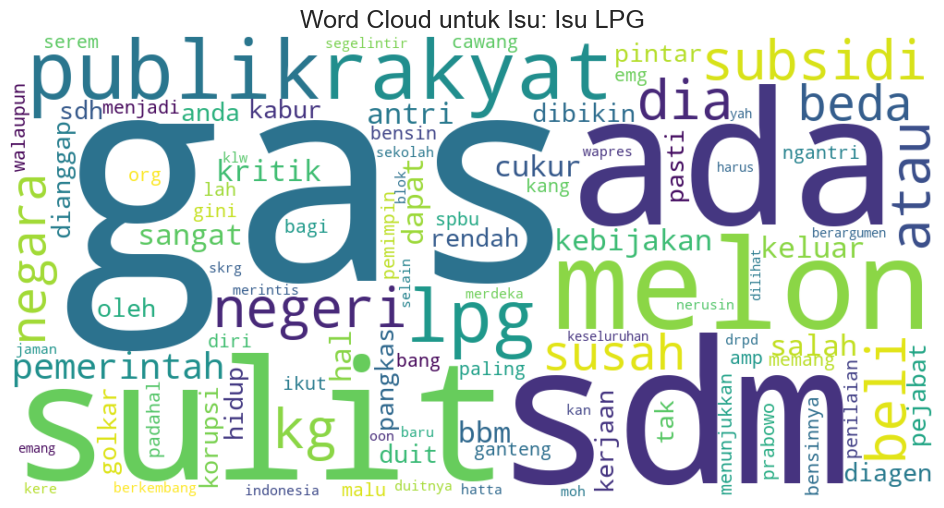


Membuat Word Cloud untuk: Isu Tambang...
Plot telah disimpan ke: wordcloud_isu_tambang.png


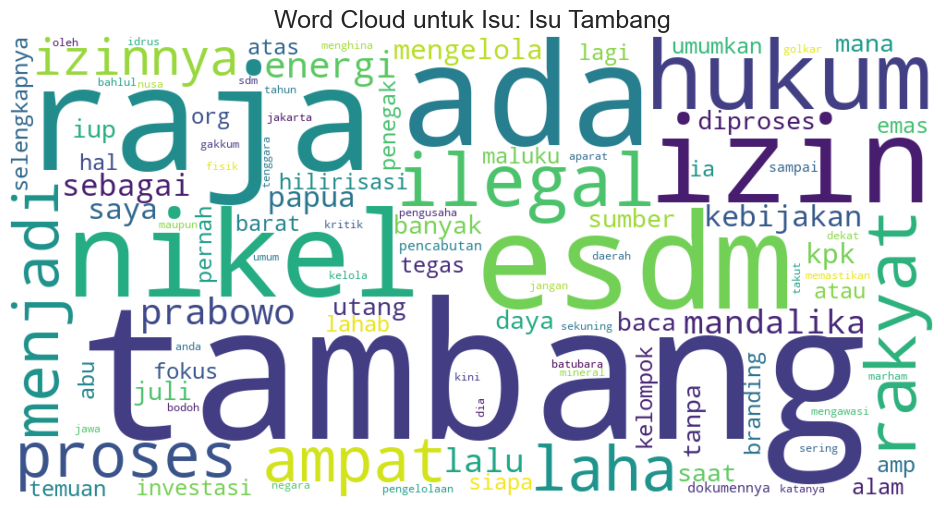


Membuat Word Cloud untuk: Isu Meme...
Plot telah disimpan ke: wordcloud_isu_meme.png


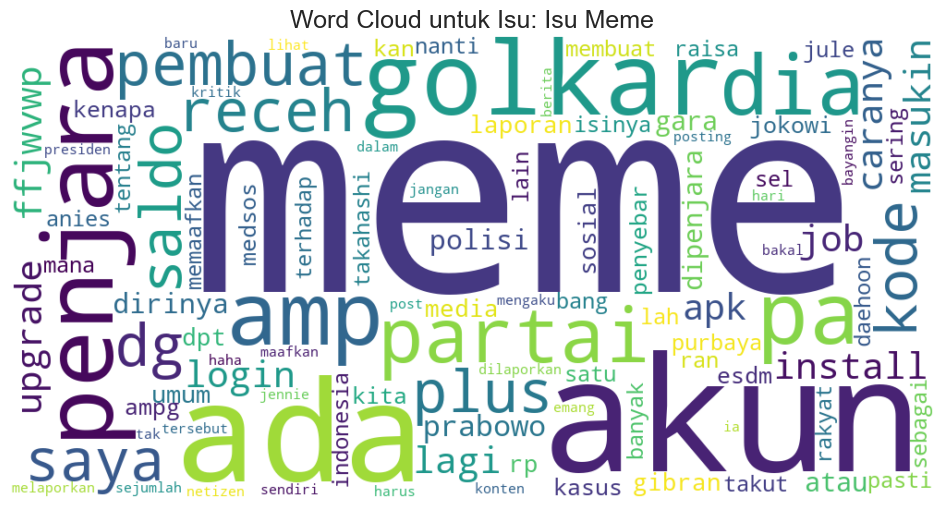


Membuat Word Cloud untuk: Isu Tumpang Tindih...
Plot telah disimpan ke: wordcloud_isu_tumpang_tindih.png


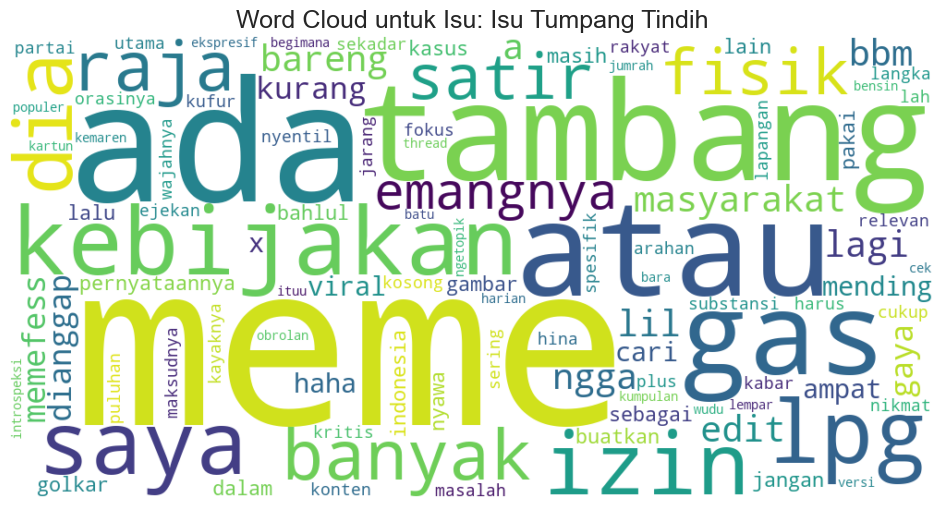


--- Proses Selesai ---


In [11]:
# --- 3. BUAT WORD CLOUD PER ISU ---

# Dapatkan daftar isu unik (misal: 'Isu Meme', 'Isu LPG', 'Isu Tambang')
unique_issues = df['isu_teridentifikasi'].unique()

print(f"\nAkan membuat word cloud untuk isu: {unique_issues}")

# Loop untuk setiap isu
for issue in unique_issues:
    if issue is None or pd.isna(issue):
        continue

    print(f"\nMembuat Word Cloud untuk: {issue}...")

    # 1. Filter DataFrame HANYA untuk isu ini
    df_isu = df[df['isu_teridentifikasi'] == issue]

    # 2. Gabungkan semua teks dari isu ini menjadi satu string panjang
    text = ' '.join(df_isu['normalized_text'])

    if not text.strip():
        print(f"Tidak ada data teks untuk isu '{issue}', dilewati.")
        continue

    # 3. Buat objek WordCloud
    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        stopwords=all_stopwords, # Gunakan daftar stopwords kita!
        colormap='viridis',
        max_words=100, # Tampilkan 100 kata teratas
        collocations=False # Nonaktifkan kata ganda (misal 'terima kasih')
    ).generate(text)

    # 4. Tampilkan plot
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Hapus sumbu x/y
    plt.title(f'Word Cloud untuk Isu: {issue}', fontsize=18)

    # 5. Simpan file plot (di folder yang sama dengan skrip)
    # Mengganti spasi atau '/' dengan '_' agar nama file aman
    safe_filename = str(issue).lower().replace(' ', '_').replace('/', '_')
    output_filename = f'wordcloud_{safe_filename}.png'

    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Plot telah disimpan ke: {output_filename}")
    plt.show()
    plt.close() # Tutup plot agar tidak tumpang tindih di loop

print("\n--- Proses Selesai ---")